# Binary xgboost on external COAD data

Generates the labelled confusion matrix for the external COAD data. Demonstrates that the worse performance is due to classifying adenomas as cancer. This is interesting.

In [1]:
cancer_type = 'COAD'

figure_folder = 'binary_xgboost_external_COAD_figs/'

Add the Evaluate module to path and make figure folder:

In [2]:
# adding this path so we can import get_train_and_test and Evaluate
import sys
import os

cwd = os.getcwd() # get the current path, and only take up to methylation-patterns-izzy (discarding the end bit)
file = 'methylation-patterns-izzy'
end = cwd.find(file) + len(file) + 1 # find start of file in path, add on its lenth to go to the end, and add on 1 to get the /
path = cwd[0:end]
print("path is ", path)
sys.path.append(path)

from Evaluate import load_and_eval
root_path = path

if not (figure_folder.strip('/') in os.listdir()):
    os.mkdir(figure_folder)

path is  /Tank/methylation-patterns-code/methylation-patterns-izzy/


Load the data:

In [3]:
# load the data
import sys
sys.path.append('/Tank/methylation-patterns-code/methylation-patterns-izzy/')
from get_train_and_test import get_external_data

m_values, diagnoses = get_external_data(cancer_type, multiclass = False, remove_inf = True, has_header = False, use_raw = True, root_path = '../new_data/colorectal carcinoma (COAD)/', use_training_imputation = True)


Using path  ../new_data/colorectal carcinoma (COAD)/m_values_from_raw_training_imputation_constant.csv
(29, 277945)
(29,)


Load model:

In [4]:
# get model
import joblib
model = joblib.load('../xgboost/saved_models/xgboost_model_COAD.pkl')

Get the predictions:

In [8]:
from Evaluate import print_evaluation

confidence = model.predict_proba(m_values)
import numpy as np
num_classes = len(np.unique(diagnoses, axis=0))
print("num classes is: ", num_classes)

from Evaluate import make_labelled_conf_mat
predictions = model.predict(m_values)


num classes is:  2


Make the diagnoses labels - Normal, Adenoma, or Cancer

In [14]:
import pandas as pd
diagnosis_info = pd.read_csv('../new_data/colorectal carcinoma (COAD)/diagnosis_info.csv', sep = '\t')
diagnosis_label = diagnosis_info['Histological Diagnosis '] # Note: need a space after
diagnosis_label = ['N' if d == 'Normal' else 'A' if d == 'Adenoma' else 'C' for d in diagnosis_label]

# diagnosis_label

diagnoses_test = diagnoses.astype('int')

Make the confusion matrix by hand:

In [47]:
# make matrix of size numclasses x numclasses
import numpy as np
mat = np.full((num_classes, num_classes), '', dtype = object)
counts = np.full((num_classes, num_classes), 0, dtype = int)

# for each sample, put it in [diagnoses_test[sample], predictions[sample]]
# this is making the annotation
for i in range(len(diagnoses_test)):
    mat[diagnoses_test[i], predictions[i]] = str(mat[diagnoses_test[i], predictions[i]]) + diagnosis_label[i] + ', '
    counts[diagnoses_test[i], predictions[i]] = counts[diagnoses_test[i], predictions[i]] + 1

    if counts[diagnoses_test[i], predictions[i]] % 3 == 0: # manually putting in new lines so the text wraps (setting the annot_kws param below doesn't seem to do anything)
        mat[diagnoses_test[i], predictions[i]] = str(mat[diagnoses_test[i], predictions[i]]) + '\n'


# mat

# this is the base confusion matrix (you need both a base cm with numbers and the annotation for seaborn's heatmap)
from sklearn import metrics
conf_mat = metrics.confusion_matrix(diagnoses_test, predictions)
   

In [48]:
mat[0][1] = '\n' + mat[0][1] # adding a new line at the beginning of two cells, so they are more centered in the plot
mat[1][1] = '\n' + mat[1][1] 

Plot it:

Text(0.5, 5.0, 'Predicted label')

Text(81.68, 0.5, 'True label')

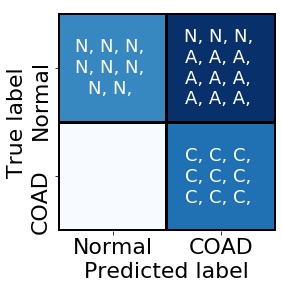

In [49]:
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)


import matplotlib.pyplot as plt
plt.clf()
import seaborn as sns
labels = ['Normal', 'COAD']
plot = sns.heatmap(conf_mat, annot=mat, fmt = "", square = True, cbar = False, cmap='Blues', linewidths=2, linecolor="black", annot_kws = {"wrap":True, "size": 18}, xticklabels = labels, yticklabels = labels)

plt.xlabel('Predicted label', fontdict = {'family' : 'normal',
        'size'   : 22})
plt.ylabel('True label', fontdict = {'family' : 'normal',
        'size'   : 22})


fig = plot.get_figure()
fig.savefig(figure_folder + 'benign_vs_cancer_confusion_matrix_COAD.svg', bbox_inches="tight")